# 📝 Exercise M7.01

In this exercise we will define dummy classification baselines and use them
as reference to assess the relative predictive performance of a given model
of interest.

We illustrate those baselines with the help of the Adult Census dataset,
using only the numerical features for the sake of simplicity.

In [1]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census-numeric-all.csv")
data, target = adult_census.drop(columns="class"), adult_census["class"]

First, define a `ShuffleSplit` cross-validation strategy taking half of the
samples as a testing at each round. Let us use 10 cross-validation rounds.

In [2]:
# Write your code here.
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=1)

Next, create a machine learning pipeline composed of a transformer to
standardize the data followed by a logistic regression classifier.

In [27]:
# Write your code here.
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

preprocessor = StandardScaler()
linear_classifier = LogisticRegression()

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", linear_classifier)
])

Compute the cross-validation (test) scores for the classifier on this
dataset. Store the results pandas Series as we did in the previous notebook.

In [28]:
# Write your code here.
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=cv)

errors_logistic_regressor = pd.Series(
    cv_results["test_score"], name="Decision logistic regressor"
)
errors_logistic_regressor.describe()

count    10.000000
mean      0.813153
std       0.001632
min       0.810245
25%       0.812037
50%       0.813091
75%       0.814340
max       0.815650
Name: Decision logistic regressor, dtype: float64

Now, compute the cross-validation scores of a dummy classifier that
constantly predicts the most frequent class observed the training set. Please
refer to the online documentation for the [sklearn.dummy.DummyClassifier
](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)
class.

Store the results in a second pandas Series.

In [29]:
# Write your code here.
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", dummy_classifier)
])

dummy_cv_results = cross_validate(model, data, target, cv=cv)

errors_dummy_regressor = pd.Series(
    dummy_cv_results["test_score"], name="Decision dummy regressor"
)
errors_dummy_regressor.describe()

count    10.000000
mean      0.760067
std       0.001259
min       0.757749
25%       0.759582
50%       0.760022
75%       0.761036
max       0.761762
Name: Decision dummy regressor, dtype: float64

Now that we collected the results from the baseline and the model,
concatenate the test scores as columns a single pandas dataframe.

In [30]:
# Write your code here.
all_errors = pd.concat(
    [errors_logistic_regressor, errors_dummy_regressor],
    axis=1,
)
all_errors

,Decision logistic regressor,Decision dummy regressor
0,0.811883,0.758773
1,0.811801,0.760206
2,0.813071,0.760043
3,0.815650,0.761599
4,0.810245,0.757749
5,0.813849,0.760002
6,0.814913,0.761312
7,0.813112,0.759551
8,0.814504,0.759674
9,0.812497,0.761762



Next, plot the histogram of the cross-validation test scores for both
models with the help of [pandas built-in plotting
function](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#histograms).

What conclusions do you draw from the results?

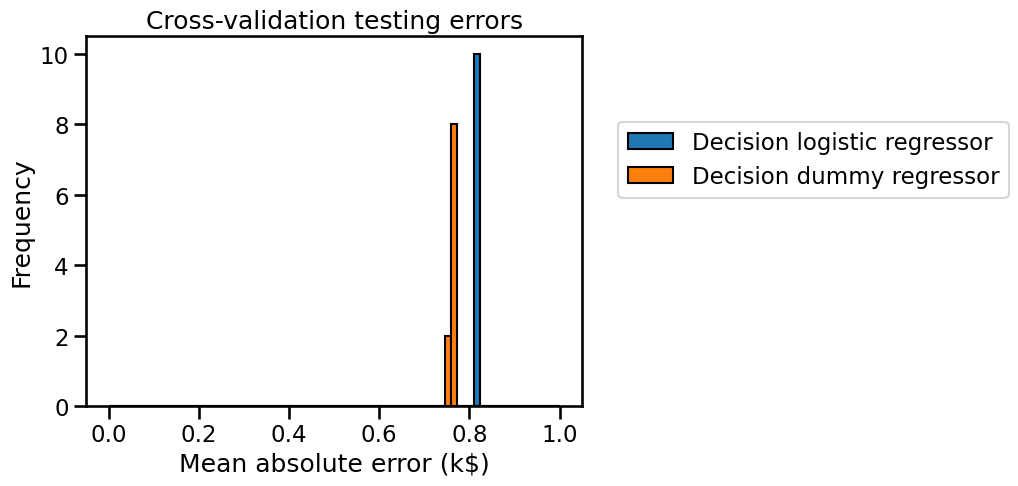

In [31]:
# Write your code here.
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(start=0, stop=1, num=80)
all_errors.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Cross-validation testing errors")

Change the `strategy` of the dummy classifier to `"stratified"`, compute the
results. Similarly compute scores for `strategy="uniform"` and then the  plot
the distribution together with the other results.

Are those new baselines better than the previous one? Why is this the case?

Please refer to the scikit-learn documentation on
[sklearn.dummy.DummyClassifier](
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)
to find out about the meaning of the `"stratified"` and `"uniform"`
strategies.

In [32]:
# Write your code here.
stratified_dummy = DummyClassifier(strategy="stratified")
cv_results_stratified = cross_validate(
    stratified_dummy, data, target, cv=cv, n_jobs=2
)
test_score_dummy_stratified = pd.Series(
    cv_results_stratified["test_score"], name="Stratified class predictor"
)

In [33]:
uniform_dummy = DummyClassifier(strategy="uniform")
cv_results_uniform = cross_validate(
    uniform_dummy, data, target, cv=cv, n_jobs=2
)
test_score_dummy_uniform = pd.Series(
    cv_results_uniform["test_score"], name="Uniform class predictor"
)

In [34]:
all_test_scores = pd.concat(
    [
        errors_logistic_regressor,
        errors_dummy_regressor,
        test_score_dummy_stratified,
        test_score_dummy_uniform,
    ],
    axis='columns',
)

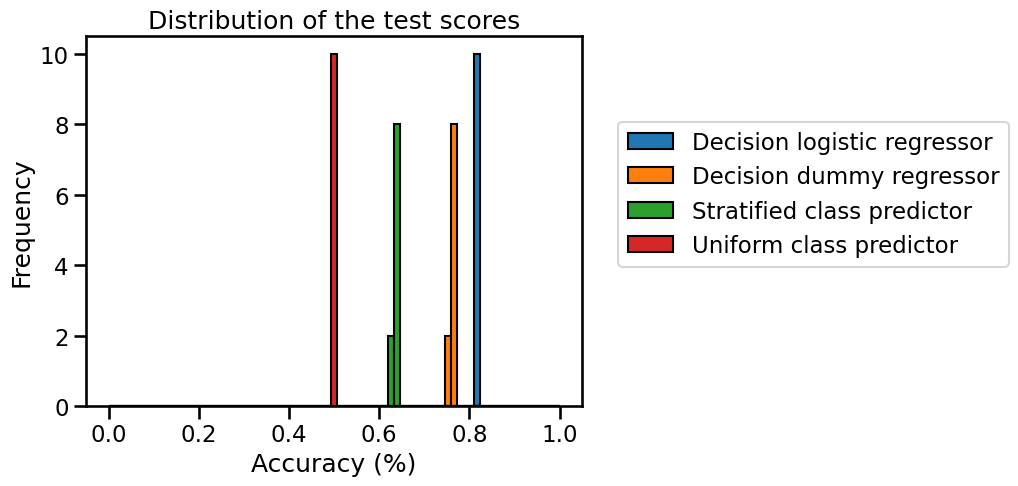

In [35]:
all_test_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Distribution of the test scores")

Note: one could argue that the `"uniform"` or `strategy="stratified"`
strategies are both valid ways to define a "chance level" baseline accuracy
for this classification problem, because they make predictions "by chance".

Another way to define a chance level would be to use the
[sklearn.model_selection.permutation_test_score](https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html)
utility of scikit-learn. Instead of using a dummy classifier, this function
compares the cross-validation accuracy of a model of interest to the
cross-validation accuracy of this same model but trained on randomly permuted
class labels. The `permutation_test_score` therefore defines a chance level
that depends on the choice of the class and hyper-parameters of the estimator
of interest. When training on such randomly permuted labels, many machine
learning estimators would end up approximately behaving much like the
`DummyClassifier(strategy="most_frequent")` by always predicting the majority
class, irrespective of the input features. As a result, this
`"most_frequent"` baseline is sometimes called the "chance level" for
imbalanced classification problems, even though its predictions are
completely deterministic and do not involve much "chance" anymore.

Defining the chance level using `permutation_test_score` is quite
computation-intensive because it requires fitting many non-dummy models on
random permutations of the data. Using dummy classifiers as baselines is
often enough for practical purposes. For imbalanced classification problems,
the `"most_frequent"` strategy is the strongest of the three baselines and
therefore the one we should use.